#Disaster Tweets


##Importing Libraries


In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from wordcloud import WordCloud, STOPWORDS 
import plotly.graph_objects as go
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("Important libraries loaded successfully")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Important libraries loaded successfully


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
pip install gcsfs

In [ ]:
data_train = pd.read_csv("gs://cmpe256_project/train.csv")
data_train.shape

(7613, 5)

## Data Preprocessing and visualizations



In [ ]:
data_train.head(100)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0


In [ ]:
NAcols=data_train.columns
for col in NAcols:
    if data_train[col].dtype == "object":
        data_train[col] = data_train[col].fillna("None")

In [ ]:
data_train.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


###Wordcloud for keyword

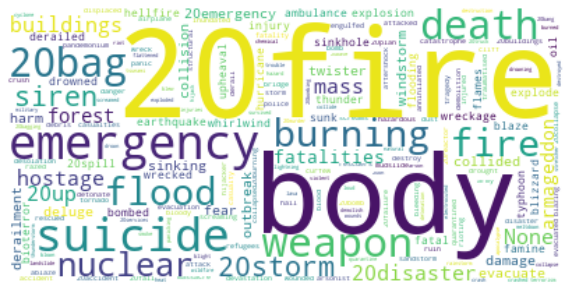

In [ ]:
import matplotlib.pyplot as plt 

#tweet_mask = np.array(Image.open("twitter-logo-png-5872.png"))
wc = WordCloud(collocations=False,
               background_color="white",
               max_words=200,
               #mask = tweet_mask,
               contour_color='steelblue',
               contour_width=10,)

# Generate a wordcloud
wc.generate(" ".join(data_train['keyword']))
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


###Distribution of real and Not-real disastrous tweets

In [ ]:
no_dis=data_train[data_train['target']==0]
yes_dis=data_train[data_train['target']==1]

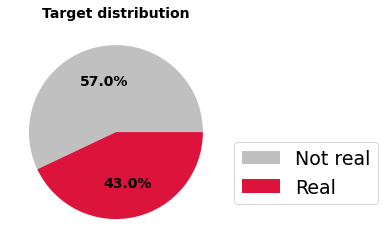

In [ ]:
target_count=data_train.target.value_counts().reset_index()

plt.pie(target_count.target,colors=("silver","crimson"), 
        autopct='%2.1f%%',textprops={'fontsize': 14, 'weight':'bold'})
lp = {'size': 19}
plt.legend(['Not real', 'Real'],prop=lp, loc='best', bbox_to_anchor=(1, 0.5))
plt.title('Target distribution', weight='bold', fontsize=14)
plt.show()

###Wordclouds of keywords in real and not-real disastrous tweets

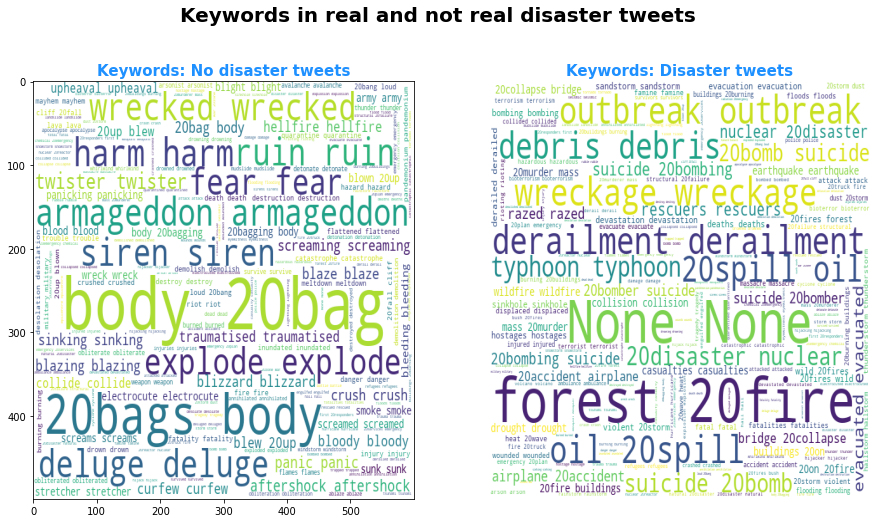

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))


fig.suptitle('Keywords in real and not real disaster tweets', weight='bold', fontsize=20)
wordcloud1 = WordCloud(width=600, height=500, background_color='white').generate(' '.join(no_dis['keyword']))
WordCloud.generate_from_frequencies
# Generate plot
wordcloud2 = WordCloud(width=600, height=500, background_color='white').generate(' '.join(yes_dis['keyword']))
WordCloud.generate_from_frequencies
# Generate plot

ax1.set_title('Keywords: No disaster tweets', weight='bold', fontsize=15, color='dodgerblue')
# Display image, `aspect='auto'` makes it fill the whole `axes` (ax3)
im1 = ax1.imshow(wordcloud1, aspect='auto')

ax2.set_title('Keywords: Disaster tweets', weight='bold', fontsize=15, color='dodgerblue')
im4 = ax2.imshow(wordcloud2, aspect='auto')

# Make space for title
plt.subplots_adjust(top=0.85)
plt.axis('off')
plt.show()

In [ ]:
#get total count of data including missing data
total = data_train.isnull().sum().sort_values(ascending=False)

#get percent of missing data relevant to all data
percent = (data_train.isnull().sum()/data_train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(data_train.shape[1])

,Total,Percent
target,0,0.0
text,0,0.0
location,0,0.0
keyword,0,0.0
id,0,0.0


In [ ]:
data_train = data_train.drop(['location','keyword'], axis=1)
print("location and keyword columns droped successfully")

location and keyword columns droped successfully


In [ ]:
data_train = data_train.drop('id', axis=1)
print("id column droped successfully")

id column droped successfully


In [ ]:
data_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
import string

In [ ]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

data_train['text_clean'] = data_train['text'].apply(lambda x: remove_URL(x))
data_train['text_clean'] = data_train['text_clean'].apply(lambda x: remove_emoji(x))
data_train['text_clean'] = data_train['text_clean'].apply(lambda x: remove_html(x))
data_train['text_clean'] = data_train['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
# Libraries for text preprocessing

from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenizing the tweet base texts.

data_train['tokenized'] = data_train['text_clean'].apply(word_tokenize)

data_train.head()

,text,target,text_clean,tokenized
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


### Character count distribution for real and not-real disastrous tweets

In [ ]:
# Creating a new feature for the visualization.

data_train['Character Count'] = data_train['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

In [ ]:
# For customizing our plots.
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

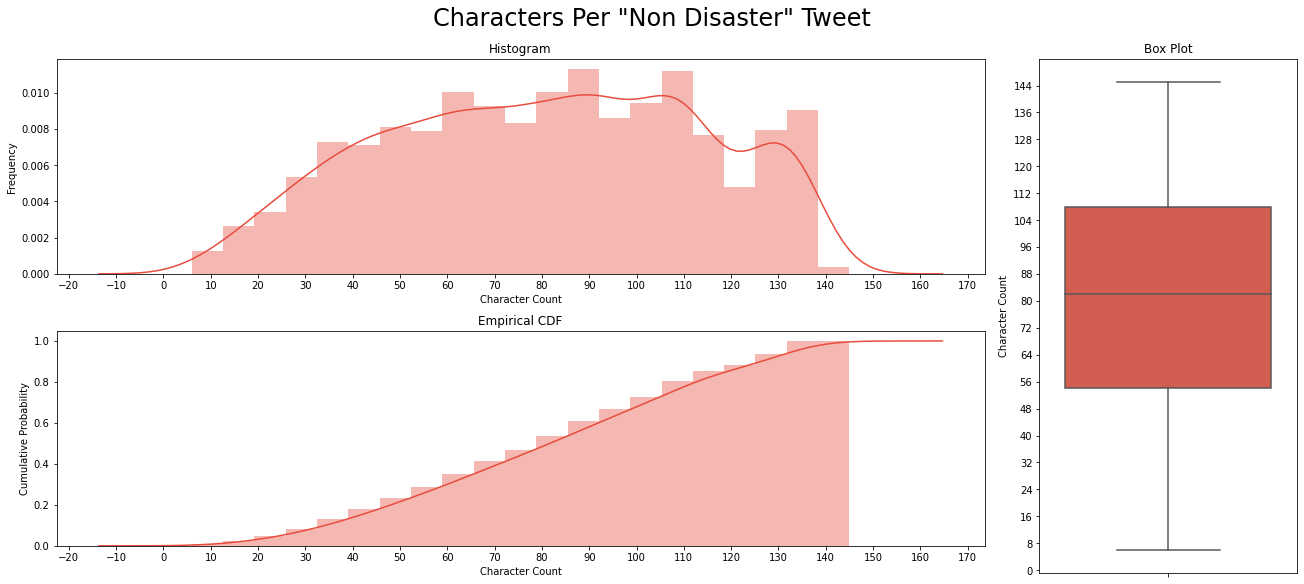

In [ ]:
plot_dist3(data_train[data_train['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

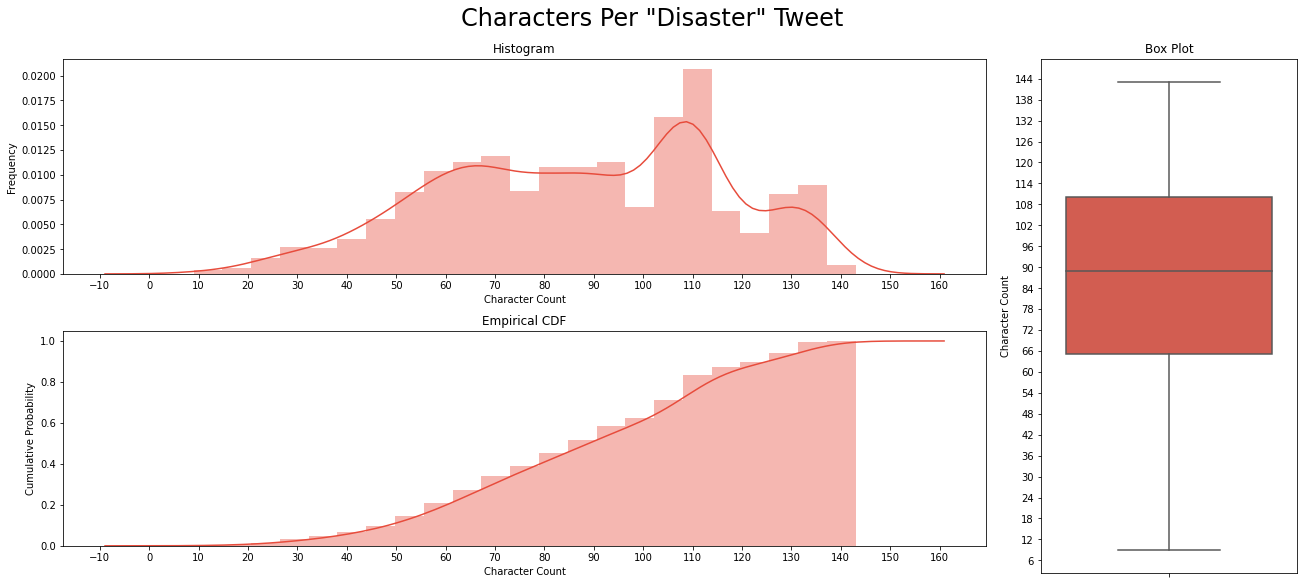

In [ ]:
plot_dist3(data_train[data_train['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

### Word count distribution for tweets

In [ ]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#32CD32')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#32CD32')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

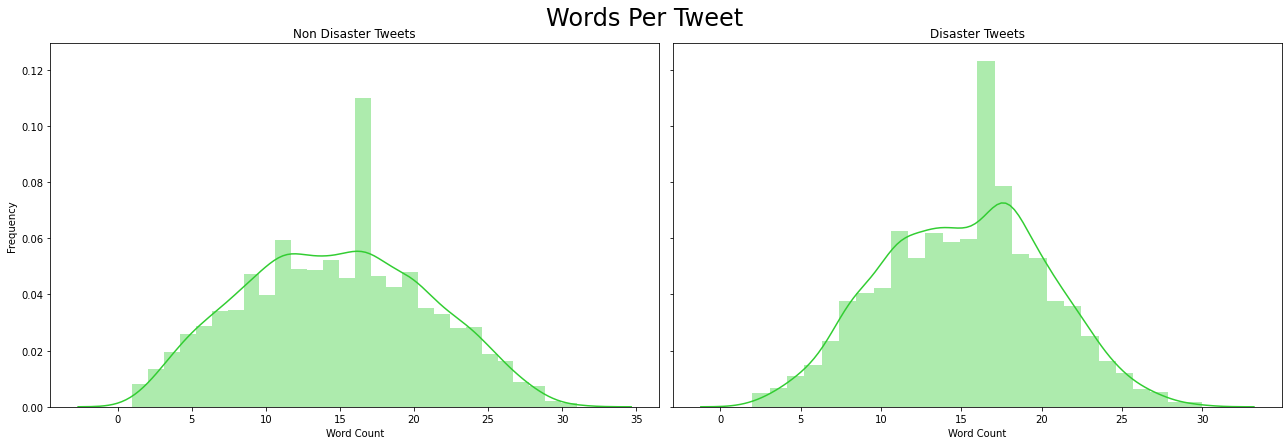

In [ ]:
plot_word_number_histogram(data_train[data_train['target'] == 0]['text'],
                           data_train[data_train['target'] == 1]['text'])

### Data preprocessing using NLTK Library

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
corpus  = []
pstem = PorterStemmer()
for i in range(data_train['text'].shape[0]):
    #Remove unwanted words
    tweet = re.sub("[^a-zA-Z]", ' ', data_train['text'][i])
    #Transform words to lowercase
    tweet = tweet.lower()
    tweet = tweet.split()
    #Remove stopwords then Stemming it
    tweet = [pstem.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    #Append cleaned tweet to corpus
    corpus.append(tweet)
    
print("Corpus created successfully") 

Corpus created successfully


In [ ]:
pd.DataFrame(corpus)[0].head(10)

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
5    rockyfir updat california hwi close direct due...
6    flood disast heavi rain caus flash flood stree...
7                               top hill see fire wood
8               emerg evacu happen build across street
9                             afraid tornado come area
Name: 0, dtype: object

In [ ]:
rawTexData = data_train["text"].head(10)
cleanTexData = pd.DataFrame(corpus, columns=['text after cleaning']).head(10)

frames = [rawTexData, cleanTexData]
result = pd.concat(frames, axis=1, sort=False)
result

,text,text after cleaning
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfir updat california hwi close direct due...
6,#flood #disaster Heavy rain causes flash flood...,flood disast heavi rain caus flash flood stree...
7,I'm on top of the hill and I can see a fire in...,top hill see fire wood
8,There's an emergency evacuation happening now ...,emerg evacu happen build across street
9,I'm afraid that the tornado is coming to our a...,afraid tornado come area


### Removing low frequency words

In [ ]:
#Create our dictionary 
uniqueWordFrequents = {}
for tweet in corpus:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1
            
#Convert dictionary to dataFrame
uniqueWordFrequents = pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['Word Frequent'])
uniqueWordFrequents.sort_values(by=['Word Frequent'], inplace=True, ascending=False)
uniqueWordFrequents.head(10)

,Word Frequent
co,4746
http,4721
like,411
fire,363
amp,344
get,311
bomb,239
new,228
via,220
u,216


In [ ]:
uniqueWordFrequents['Word Frequent'].unique()

array([4746, 4721,  411,  363,  344,  311,  239,  228,  220,  216,  213,
        210,  209,  201,  183,  181,  180,  178,  175,  169,  166,  164,
        162,  156,  155,  153,  151,  145,  144,  143,  137,  133,  132,
        131,  130,  129,  128,  125,  124,  123,  122,  121,  120,  119,
        118,  117,  116,  114,  111,  110,  109,  108,  106,  105,  104,
        103,  102,  101,  100,   99,   98,   97,   96,   95,   94,   93,
         91,   90,   89,   88,   87,   86,   84,   83,   82,   79,   78,
         77,   76,   75,   74,   73,   72,   71,   70,   69,   68,   67,
         66,   65,   64,   63,   62,   61,   60,   59,   58,   57,   56,
         55,   54,   53,   52,   51,   50,   49,   48,   47,   46,   45,
         44,   43,   42,   41,   40,   39,   38,   37,   36,   35,   34,
         33,   32,   31,   30,   29,   28,   27,   26,   25,   24,   23,
         22,   21,   20,   19,   18,   17,   16,   15,   14,   13,   12,
         11,   10,    9,    8,    7,    6,    5,   

In [ ]:
uniqueWordFrequents = uniqueWordFrequents[uniqueWordFrequents['Word Frequent'] >= 20]
print(uniqueWordFrequents.shape)
uniqueWordFrequents

(787, 1)


,Word Frequent
co,4746
http,4721
like,411
fire,363
amp,344
...,...
cnn,20
gem,20
captur,20
arriv,20


### Create sparse matrix ( Bag of words )

In [ ]:
counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
bagOfWords = counVec.fit_transform(corpus).toarray()

## Models Bulding

In [ ]:
X = bagOfWords
y = data_train['target']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.20, random_state=55, shuffle =True)
print('data splitting successfully')

X shape =  (7613, 787)
y shape =  (7613,)
data splitting successfully


### Decision Tree Model

In [ ]:
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)

decisionTreeModel.fit(X_train,y_train)

print("decision Tree Classifier model run successfully")

decision Tree Classifier model run successfully


###Gradient Boosting Model

In [ ]:
gradientBoostingModel = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=55)

gradientBoostingModel.fit(X_train,y_train)

print("gradient Boosting Classifier model run successfully")

gradient Boosting Classifier model run successfully


###K Neighbours Model

In [ ]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')

KNeighborsModel.fit(X_train,y_train)

print("KNeighbors Classifier model run successfully")

KNeighbors Classifier model run successfully


###Logistic Regression Model

In [ ]:
LogisticRegression = LogisticRegression(penalty='l2', 
                                        solver='saga', 
                                        random_state = 55)  

LogisticRegression.fit(X_train,y_train)

print("LogisticRegression Classifier model run successfully")

LogisticRegression Classifier model run successfully


###SGD Classifier Model

In [ ]:
SGDClassifier = SGDClassifier(loss = 'hinge', 
                              penalty = 'l1',
                              learning_rate = 'optimal',
                              random_state = 55, 
                              max_iter=100)

SGDClassifier.fit(X_train,y_train)

print("SGDClassifier Classifier model run successfully")

SGDClassifier Classifier model run successfully


###SVC Classifier Model

In [ ]:
SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10000,
                   C=2, 
                   random_state = 55)

SVClassifier.fit(X_train,y_train)

print("SVClassifier model run successfully")

SVClassifier model run successfully


###Bernoulli Model

In [ ]:
bernoulliNBModel = BernoulliNB(alpha=0.1)
bernoulliNBModel.fit(X_train,y_train)

print("bernoulliNB model run successfully")

bernoulliNB model run successfully


###Gaussian Model

In [ ]:
gaussianNBModel = GaussianNB()
gaussianNBModel.fit(X_train,y_train)

print("gaussianNB model run successfully")

gaussianNB model run successfully


###Multinomial Model

In [ ]:
multinomialNBModel = MultinomialNB(alpha=0.1)
multinomialNBModel.fit(X_train,y_train)

print("multinomialNB model run successfully")

multinomialNB model run successfully


###Voting Classifier Model

In [ ]:
modelsNames = [('LogisticRegression',LogisticRegression),
               ('SGDClassifier',SGDClassifier),
               ('SVClassifier',SVClassifier),
               ('bernoulliNBModel',bernoulliNBModel),
               ('multinomialNBModel',multinomialNBModel)]

votingClassifier = VotingClassifier(voting = 'hard',estimators= modelsNames)
votingClassifier.fit(X_train,y_train)
print("votingClassifier model run successfully")

votingClassifier model run successfully


###Model evaluation for above models

In [ ]:
#evaluation Details
models = [decisionTreeModel, gradientBoostingModel, KNeighborsModel, LogisticRegression, 
          SGDClassifier, SVClassifier, bernoulliNBModel, gaussianNBModel, multinomialNBModel, votingClassifier]

for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_train, y_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_test,y_pred))
    print('--------------------------------------------------------------------------')

DecisionTreeClassifier  Train Score is   :  0.9761904761904762
DecisionTreeClassifier  Test Score is    :  0.7419566644780039
DecisionTreeClassifier  F1 Score is      :  0.6743993371996686
--------------------------------------------------------------------------
GradientBoostingClassifier  Train Score is   :  0.8586206896551725
GradientBoostingClassifier  Test Score is    :  0.7544320420223244
GradientBoostingClassifier  F1 Score is      :  0.6375968992248061
--------------------------------------------------------------------------
KNeighborsClassifier  Train Score is   :  0.9761904761904762
KNeighborsClassifier  Test Score is    :  0.7406434668417596
KNeighborsClassifier  F1 Score is      :  0.5872518286311389
--------------------------------------------------------------------------
LogisticRegression  Train Score is   :  0.8502463054187193
LogisticRegression  Test Score is    :  0.7826657912015759
LogisticRegression  F1 Score is      :  0.7230125523012553
-------------------------

#Convolution Neural Network Model

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

hub_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-500-with-normalization/2",input_shape=[], dtype=tf.string)



In [ ]:
model = tf.keras.Sequential()

In [ ]:
model.add(hub_layer)

In [ ]:
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.BatchNormalization())

In [ ]:
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 500)               504687500 
_________________________________________________________________
dense (Dense)                (None, 128)               64128     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                1

##Optimization Techniques


In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(Adam(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
import keras
file_path='my_model_file.h5'
callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 15 # Stop after 15 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = file_path, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [ ]:

train_data=data_train.text.values
train_labels=data_train.target.values
history = model.fit(
    train_data,train_labels,
    validation_split=0.3,
    epochs=30,
    callbacks=None,
    batch_size=20
)

Epoch 1/30
267/267 [==============================] - 1s 4ms/step - loss: 0.7119 - accuracy: 0.6273 - val_loss: 0.6339 - val_accuracy: 0.5727
Epoch 2/30
267/267 [==============================] - 1s 3ms/step - loss: 0.5968 - accuracy: 0.7056 - val_loss: 0.4876 - val_accuracy: 0.7855
Epoch 3/30
267/267 [==============================] - 1s 3ms/step - loss: 0.5631 - accuracy: 0.7322 - val_loss: 0.4504 - val_accuracy: 0.7960
Epoch 4/30
267/267 [==============================] - 1s 3ms/step - loss: 0.5494 - accuracy: 0.7437 - val_loss: 0.4414 - val_accuracy: 0.8017
Epoch 5/30
267/267 [==============================] - 1s 3ms/step - loss: 0.5350 - accuracy: 0.7386 - val_loss: 0.4417 - val_accuracy: 0.8021
Epoch 6/30
267/267 [==============================] - 1s 3ms/step - loss: 0.5182 - accuracy: 0.7561 - val_loss: 0.4404 - val_accuracy: 0.7968
Epoch 7/30
267/267 [==============================] - 1s 3ms/step - loss: 0.5174 - accuracy: 0.7606 - val_loss: 0.4405 - val_accuracy: 0.8025
Epoch 

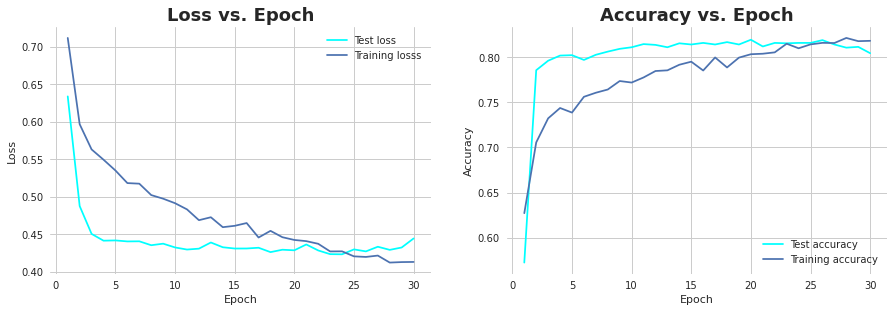

In [ ]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))
#First Model
ax1 = plt.subplot2grid((2,2),(0,0))
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'cyan', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch',weight='bold', fontsize=18)
ax1 = plt.subplot2grid((2,2),(0,1))
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'cyan', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()


##Prediction

In [ ]:
test_data = pd.read_csv('gs://cmpe256_project/test.csv')
test_data = test_data.text.values
prediction = model.predict(test_data)
print("Prediction Values")
prediction

Prediction Values


array([[0.63953614],
       [0.7994441 ],
       [0.7454959 ],
       ...,
       [0.96345454],
       [0.83740735],
       [0.44925448]], dtype=float32)